## 完成したtrain copy.ipynb　を使って、ある条件を基に格子を集めていくものを作りたい
2024/5/17 時点での完成版

コードをすべて問題なく実行できるようにはなった。
最適化されたメッシュを取り出してくることもでき、しっかり更新できている。
しかし、損失の値が全く減少せず、むしろ増加していてほぼもともとのメッシュのままの出力が最適化メッシュとして出てきてしまう。
ゆえに、最適化できているとは到底言えない。





trainを実行するためのコード

・各epoch後のメッシュの表示


・学習率を0.1倍から0.95倍にしてみる

・シフト切り捨ては推論時飲み使用する

・バッチサイズを変えてみる

・モデルの出力を0.5倍するなどして移動量を小さくする

・学習時はMetricLossで、最適メッシュを選定するときは違う関数なのはなんで

# シフト切り捨てをやめてみる
# トレーニング完了後のトレーニングメッシュを表示してみる
# 各epochの終了時にメッシュを可視化してみる

In [1]:
import copy
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GraphNorm, LayerNorm
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch.nn import Linear, InstanceNorm2d, InstanceNorm1d, Conv1d, ReLU, Tanh
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random
import matplotlib.pyplot as plt
from torch_geometric.transforms import FaceToEdge
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from itertools import combinations
import vtk
import glob
from tqdm import tqdm
# 計算を軽くするためのライブラリ
from torch.cuda import empty_cache
import gc               # メモリリークを防ぐ

from torch import nn
import os
import sys

import datetime

In [2]:
torch.cuda.is_available()

True

In [3]:
num_train_epoch = 40
train_data_path = "/mnt/featured_optimizer/prepared_test_mesh_featured/"
fig_save_path = "/mnt/featured_optimizer/trained_mesh/"
vtk_save_path = "/mnt/featured_optimizer/trained_data/"

# Dataの準備

In [4]:
class Dataset(Dataset):
    def __init__(self, num_files):
        None

class Mesh(Dataset):
    def __init__(self):
        self.coordinates = None
        self.faces = None
        self.features = None

class Polygon(Dataset):
    def __init__(self, num_node, num_face):
        self.parent_meshID = None
        self.coordinates = torch.zeros(num_node, 2)
        self.faces = torch.zeros(num_face, 3)
        self.edge_index = None
        self.edges = None
        self.d = None
        self.Cx = None
        self.Cy = None
        self.x_min = None
        self.y_min = None
        self.features = None
        self.boundary_checker = None

    def to(self, device):
        # GPUに移動可能なtorch.Tensor変数を移動
        self.coordinates = self.coordinates.to(device)
        self.faces = self.faces.to(device)
        if self.edge_index is not None:
            self.edge_index = self.edge_index.to(device)
        if self.edges is not None:
            self.edges = self.edges.to(device)
        if self.d is not None:
            self.d = self.d.to(device)
        if self.Cx is not None:
            self.Cx = self.Cx.to(device)
        if self.Cy is not None:
            self.Cy = self.Cy.to(device)
        if self.x_min is not None:
            self.x_min = self.x_min.to(device)
        if self.y_min is not None:
            self.y_min = self.y_min.to(device)
        if self.features is not None:
            self.features = self.features.to(device)
        if self.boundary_checker is not None:
            self.boundary_checker = self.boundary_checker.to(device)


class PolygonID(Dataset):
    def __init__(self, nodeID):
        self.nodeID = nodeID
        # self.parent_meshID = None

class Polygon_data(Dataset):
    def __init__(self, polygonID, meshID, nodeID, boundary_checker):
        self.polygonID = polygonID
        self.meshID = meshID
        self.nodeID = nodeID
        self.boundary_checker = boundary_checker

class Minibatch(Dataset):
    def __init__(self):
        self.x = None
        self.edge_index = None
        self.batch = None

class EarlyStopping:
    def __init__(self, patience, min_delta):
        self.patience = patience      # 損失が改善しないエポック数の上限
        self.min_delta = min_delta    # 損失が改善とみなす最小値
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [5]:
def create_mesh_polygonID_data(vtk_file_path, polygonID_list, poly_count, polygon_dict, mesh_index):
    reader = vtk.vtkDataSetReader()
    reader.SetFileName(vtk_file_path)
    reader.Update()

    data = reader.GetOutput()
    
    mesh = Mesh()
    # 座標情報を取得
    points = data.GetPoints()
    num_points = points.GetNumberOfPoints()
    coordinates = torch.zeros(num_points, 3)
    for i in range(num_points):
        coordinates[i] = torch.tensor(points.GetPoint(i))

    mesh.coordinates = coordinates[:, :2]                        # mesh.coordinates を定義

    # 面情報を取得
    polys = data.GetPolys()                                     #すべての面情報を取得
    num_polys = polys.GetNumberOfCells()                        #面の数を取得
    mesh.faces = torch.zeros(num_polys, 3, dtype=int)           # 面情報を格納するための行列を定義

    # 各三角形の情報を取得
    polys.InitTraversal()                                       #イテレーションを初期化
    for i in range(num_polys):                          
        cell = vtk.vtkIdList()                                  #vtk.vtkIdList()オブジェクトを作成
        # print(cell)                                     
        if polys.GetNextCell(cell) == 0:                        #次のセル（ポリゴン）を取得し、cellにその情報を格納
            break
        mesh.faces[i] = torch.tensor([cell.GetId(0), cell.GetId(1), cell.GetId(2)]) #セル（ポリゴン）の頂点IDを格納

    # 各面にfeature(pressure)情報を取得
    cell_data = data.GetCellData()
    if cell_data.HasArray("pressure"):  # 'pressure'データがある場合
        pressure_array = cell_data.GetArray("pressure")
        num_cells = pressure_array.GetNumberOfTuples()
        mesh.features = torch.zeros(num_cells, 1)  # pressureデータ用のテンソルを定義

        # pressureデータをテンソルに格納
        for i in range(num_cells):
            mesh.features[i, 0] = pressure_array.GetValue(i)

        print("Pressure data successfully extracted.")
    else:
        print("No pressure field found in CELL_DATA.")


        
# ------------ mesh のデータを取得完了 -------------------------


    # 各セルの各辺の隣接セル数を調べる
    edge_neighbors = {}
    num_cells = data.GetNumberOfCells()
    for cell_index in range(num_cells):
        cell = data.GetCell(cell_index)
        num_edges = cell.GetNumberOfEdges()

        for edge_index in range(num_edges):
            edge = cell.GetEdge(edge_index)
            edge_points = edge.GetPointIds()

            # 辺を構成する点のインデックスを取得
            point1_id = edge_points.GetId(0)
            point2_id = edge_points.GetId(1)

            # 辺を構成する点のインデックスを昇順にソート
            edge_key = (min(point1_id, point2_id), max(point1_id, point2_id))

            # 辺の隣接セル数をカウント
            if edge_key in edge_neighbors:
                edge_neighbors[edge_key] = edge_neighbors[edge_key] +1
            else:
                edge_neighbors[edge_key] = 1 

    boundary_edges = []
    # 境界上の辺を特定
    for edge_key, num_neighbors in edge_neighbors.items():
        if num_neighbors == 1:
            boundary_edges.append(edge_key)

    # 境界上の辺を構成する頂点の番号を取得
    boundary_points = set()     # 集合を表すデータ型、順番を持たず、重複した要素は取り除かれる
# ---------------- 自由点かどうかの判定完了 ------------------------
    

    for edge_key in boundary_edges:
        boundary_points.add(edge_key[0])
        boundary_points.add(edge_key[1])
    
    
    for pointId in range(num_points):       # pointId:自由点の頂点番号
        if pointId in boundary_points:
            continue
        else:
            poly_count = poly_count + 1
            # print("pointId:", pointId)
        mask = (mesh.faces == pointId)
        if mask.any():
            count = torch.sum(mask).item()  
        num_node = count + 1
        num_face = count
        polygon_number = poly_count - 1 



        
        polygon_i = f"polygon_{polygon_number}"
        # print(polygon_i)
        polygon_i = Polygon(num_node, num_face)
        
        element_to_check = pointId
        polygon_i.face = mesh.faces[(mesh.faces == element_to_check).any(dim=1)]
        # print(polygon_i.face)

        polygon_i.nodeId = set()
        for i in range(len(polygon_i.face)):
            polygon_i.nodeId.add(polygon_i.face[i, 0].item())
            polygon_i.nodeId.add(polygon_i.face[i, 1].item())
            polygon_i.nodeId.add(polygon_i.face[i, 2].item())
        sorted_nodeId = sorted(polygon_i.nodeId)
        polygon_i.nodeID = torch.tensor(list(sorted_nodeId))
        
        point_id_index = (polygon_i.nodeID == pointId).nonzero().item()

        value_to_move = polygon_i.nodeID[point_id_index]
        polygon_i.nodeID = torch.cat((value_to_move.unsqueeze(0), polygon_i.nodeID[polygon_i.nodeID != pointId]))
        # print(polygon_i.nodeID)
        if any(node in boundary_points for node in polygon_i.nodeID.tolist()):
            polygon_i.boudary_checker = torch.tensor(0)
        else:
            polygon_i.boundary_checker = torch.tensor(1)

        setattr(polygon_i, "parent_meshID", mesh)
        polygonID_list.append(f"polygon_{polygon_number}")

        keyword = f"polygon_{polygon_number}"
        valiables = (f"mesh_{mesh_index}", polygon_i.nodeID, polygon_i.boundary_checker)
        polygon_dict[keyword] = valiables

        

    # --------- polygon.nodeID の取得完了 -------------
    return mesh, polygonID_list, poly_count, polygon_dict

# Dataset の作成

In [6]:
def create_mesh_polygon_dataset(vtk_files):
    num_vtk_files = len(vtk_files)
    polygonID_list = []
    mesh_data_list = []
    poly_count = 0
    polygon_dict = {}
    # ファイルに順にアクセスする
    for i in range(num_vtk_files):
        # print("File Name:", vtk_files[i])
        mesh, polygonID_list, poly_count, polygon_dict = create_mesh_polygonID_data(vtk_files[i], polygonID_list, poly_count, polygon_dict, i)
        mesh_data_list.append(mesh)
    return mesh_data_list, polygonID_list, polygon_dict


In [7]:
# 以下、i はpolygon番号で座標と面情報を取得することができる
face_to_edge = T.FaceToEdge(remove_faces=False)
def data_getter(polygonID, num_mesh_data_list, mesh_data_list, polygon_data_list):
    
    polygon_meshID = int(polygon_data_list[polygonID].meshID.split("_")[-1])
    mesh = mesh_data_list[polygon_meshID]
    
    num_node = len(polygon_data_list[polygonID].nodeID)
    num_face = num_node - 1 
    polygon_i = Polygon(num_node, num_face)

    # print(polygon_data_list[polygonID].nodeID)      # polygon に属する頂点の番号

    polygon_i.coordinates = mesh.coordinates[polygon_data_list[polygonID].nodeID]     # polygonの座標
    polygon_i.boundary_checker = polygon_data_list[polygonID].boundary_checker
    # print(polygon_i.coordinates)

    # print(polygon_i.faces)

    # polygon_i.faces を取得するコード
    
    element_to_check = polygon_data_list[polygonID].nodeID[0]
    polygon_i.face = mesh.faces[(mesh.faces == element_to_check).any(dim=1)]
    polygon_i.features = mesh.features[(mesh.faces == element_to_check).any(dim=1)]

    indices = torch.nonzero(torch.isin(polygon_i.face, polygon_data_list[polygonID].nodeID))
    for idx in range(indices.size(0)):
        row_idx, col_idx = indices[idx]
        value_to_replace = polygon_i.face[row_idx, col_idx]
        polygon_i.face[row_idx, col_idx] = (polygon_data_list[polygonID].nodeID == value_to_replace).nonzero().item()
    polygon_i.faces = polygon_i.face.long()

    # 各行の三角形からエッジを抽出してedge_indexを構築
    edges = torch.cat([ polygon_i.faces[:, [0, 1]],
                        polygon_i.faces[:, [1, 2]],
                        polygon_i.faces[:, [2, 0]]], dim=0)

    # エッジのインデックスをソートして重複を削除
    edge_index = torch.sort(edges, dim=1).values
    edge_index = torch.tensor(sorted(edge_index.numpy().tolist())).unique(dim=0)
    polygon_i.edge_index = torch.transpose(edge_index, 0, 1)
    return polygon_i



# メッシュをプロットする関数

In [8]:
def plot_mesh(mesh, title):

    vertices = mesh.coordinates
    faces = mesh.faces
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect="equal")

    # 各三角形をプロット
    for face in faces:
        v0, v1, v2 = vertices[face]
        v0_np = v0.detach().numpy()
        v1_np = v1.detach().numpy()
        v2_np = v2.detach().numpy()
        ax.plot([v0_np[0], v1_np[0], v2_np[0], v0_np[0]], [v0_np[1], v1_np[1], v2_np[1], v0_np[1]], 'b-')  # 三角形を赤色の線でプロット

    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.axhline(0, color="black", linewidth=0.001)
    ax.axvline(0, color="black", linewidth=0.001)

    plt.show()
    plt.close()


In [9]:
def save_mesh(mesh, title):

    vertices = mesh.coordinates
    faces = mesh.faces
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect="equal")


    # 各三角形をプロット
    for face in faces:
        v0, v1, v2 = vertices[face]
        v0_np = v0.detach().numpy()
        v1_np = v1.detach().numpy()
        v2_np = v2.detach().numpy()
        ax.plot([v0_np[0], v1_np[0], v2_np[0], v0_np[0]], [v0_np[1], v1_np[1], v2_np[1], v0_np[1]], 'b-')  # 三角形を赤色の線でプロット

    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.axhline(0, color="black", linewidth=0.001)
    ax.axvline(0, color="black", linewidth=0.001)

    plt.savefig(f"{fig_save_path}{title}.png", format="png")
    # plt.show()
    plt.close()

# meshデータからvtkファイルを出力する関数

In [10]:
def vtk_output(mesh, title):
    vertices = mesh.coordinates
    faces = mesh.faces
    features = mesh.features
    num_vertices = len(vertices)
    num_faces = len(faces)
    num_features = len(features)


    # vertices を３次元に戻す
    z_column = torch.zeros(vertices.shape[0], 1)
    vertices = torch.cat((vertices, z_column), dim=1)

    with open(f"{vtk_save_path}{title}.vtk", "w") as f:
        f.write("# vtk DataFile Version 2.0\n")
        f.write("FOR TEST\n")
        f.write("ASCII\n")
        f.write("DATASET POLYDATA\n")

        f.write("POINTS {} float\n".format(num_vertices))
        for vertex in vertices:
            f.write("{:.15f} {:.15f} {:.15f}\n".format(*vertex))

        f.write("\nPOLYGONS {} {}\n".format(num_faces, num_faces * 4))
        for face in faces:
            f.write("3 ")
            f.write(" ".join(str(idx.item()) for idx in face))
            f.write("\n")

        f.write("\n")
        f.write("CELL_DATA {}\n".format(num_features))
        f.write("SCALARS pressure float 1\n")
        f.write("LOOKUP_TABLE default\n")
        for feature in range(num_features):
            f.write(str(features[feature].item()))
            f.write("\n")



# Normalization

In [11]:
def normalization(polygon):
    vertices = polygon.coordinates.to(device)
    normalized_vertices = vertices.to(device)
    centered_vertices = vertices.to(device)
    # print(vertices)

    max_x = torch.max(vertices[:,0]).to(device)
    min_x = torch.min(vertices[:,0]).to(device)
    max_y = torch.max(vertices[:,1]).to(device)
    min_y = torch.min(vertices[:,1]).to(device)

    polygon.d = torch.max(max_x - min_x, max_y - min_y).to(device)
    polygon.x_min = min_x.to(device)
    polygon.y_min = min_y.to(device)

    normalized_vertices = (vertices - torch.tensor([polygon.x_min, polygon.y_min]).to(device)) / polygon.d
    normalized_vertices.to(device)

    
    polygon.Cx = torch.tensor(normalized_vertices[0,0].item()).to(device)
    polygon.Cy = torch.tensor(normalized_vertices[0,1].item()).to(device)

    centered_vertices = normalized_vertices - torch.tensor([polygon.Cx, polygon.Cy]).to(device)
    polygon.coordinates = centered_vertices
    
    # print("Normalized polygon:", vertices)

    return polygon


    


# denormalization

In [12]:
def denormalization(polygon):
    vertices = polygon.coordinates.to(device)
    shifted_vertices = vertices.to(device)
    denormalized_vertices = vertices.to(device)
    
    shifted_vertices = vertices + torch.tensor([polygon.Cx, polygon.Cy]).to(device)
    
    
    denormalized_vertices = polygon.d * shifted_vertices + torch.tensor([polygon.x_min, polygon.y_min]).to(device)
    polygon.coordinates = denormalized_vertices
    return polygon


# Downscaling

In [13]:
def downscaling(polygon):
    vertices = polygon.coordinates
    polygon.coordinates = vertices * 0.99

    return polygon

In [14]:
def upscaling(polygon):
    vertices = polygon.coordinates
    polygon.coordinates = vertices * 1.01

    return polygon

In [15]:
def changescaling(polygon, gap):
    vertices = polygon.coordinates
    polygon.coordinates = vertices * ( 0.01/(gap + 1) + 0.99)

    return polygon

# MetricLoss

In [16]:
# ログをファイルに保存するようにしている
import sys

import logging

logging.basicConfig(
    filename='metric_loss.log',
    level=logging.DEBUG, 
    format='%(message)s'
)

# logger = logging.getLogger(__name__)

class MetricLoss:
    def select_vertices(self, vertices, face):
        v0 = vertices[face[0]].to(device)
        v1 = vertices[face[1]].to(device)
        v2 = vertices[face[2]].to(device)
        if torch.isnan(v0).any() or torch.isnan(v1).any() or torch.isnan(v2).any():
            print("Error in vertices")
            
        return v0, v1, v2 

    def edge_length(self, v0, v1, v2):
        l1 = torch.sqrt((v0[0] - v1[0])**2 + (v0[1] - v1[1])**2)
        l2 = torch.sqrt((v1[0] - v2[0])**2 + (v1[1] - v2[1])**2)
        l3 = torch.sqrt((v2[0] - v0[0])**2 + (v2[1] - v0[1])**2)
        if torch.isnan(l1) or torch.isnan(l2) or torch.isnan(l3):
            print("Error in edge_length")
        return l1, l2, l3

    def face_area(self, polygon, l1, l2, l3):   # エラーのときはポリゴンを表示する
        
        s = 0.5*(l1 + l2 + l3)
        #print(round(l1.item(),5), round(l2.item(),5), round(l3.item(),5), round(s.item(),5), round((s*(s-l1)*(s-l2)*(s-l3)).item(),5))
        temp = s*(s-l1)*(s-l2)*(s-l3)
        #temp.register_hook(print_grad)
        # logger.info("    s, in_sqrt: {}, {}".format(s.item(), temp.item()))
        
        # try:
            
        face_area = torch.sqrt(temp)
            
        # except Exception as e:
            
            # SimplePolygonGenerator.polygon_visualizer(polygon)
            
            # print("An error occurred")
            # print("Value of temp:", temp)
            # print(l1.item(), l2.item(), l3.item())
            
        #     raise
        if torch.isnan(face_area):
            print("Error in face_area")
            print("temp:", temp)
        #face_area = torch.sqrt(temp)
        #face_area.register_hook(print_grad)
        return face_area

    def compute_loss(self, polygon, vertices, face, dx):
        v0, v1, v2 = self.select_vertices(vertices, face)
                  # わからんけどどれか原点にあるやつが自由点だからそれを移動させよう
        # if face[0]==0:
        #     v0 = v0 + dx
        # elif face[1]==0:
        #     v1 = v1 + dx
        # elif face[2]==0:
        #     v2 = v2 + dx
        #print(v0, v1, v2)
        # logger.info("    v0: ({}, {})".format(v0[0].item(), v0[1].item()))
        # logger.info("    v1: ({}, {})".format(v1[0].item(), v1[1].item()))
        # logger.info("    v2: ({}, {})".format(v2[0].item(), v2[1].item()))
        l1, l2, l3 = self.edge_length(v0, v1, v2)
        # logger.info("    l1, l2, l3:  {}, {}, {}".format(l1.item(), l2.item(), l3.item()))
        s = self.face_area(polygon, l1, l2, l3)
        #print(s.item(), l1.item(), l2.item(), l3.item())

        #q = (l1**2 + l2**2 + l3**2)/(4.0*torch.sqrt(torch.tensor(3.))*s+1.0)
        
        #loss = 1 - 1/q
        #print(q.item(), loss.item())
        
        #q = q.clone().detach().requires_grad_(True)
        loss = 1-(4.0*torch.sqrt(torch.tensor(3.))*s)/(l1**2 + l2**2 + l3**2)
        # logger.info("    area, loss: {}, {}".format(s.item(), loss.item()))
        # logger.info("")
        #print(loss.item())
        #print("")
        
        #loss.register_hook(print_grad)
        
        return loss

    def __call__(self, polygon, dx=None):
        vertices = polygon.coordinates
        faces = polygon.faces
        loss = torch.tensor(0.0)
        for face in faces:
            loss = loss + self.compute_loss(polygon, vertices, face, dx)
        
        metric_loss = loss/(len(polygon.coordinates[:,0])-1) #.clone().detach().requires_grad_(True))
        if torch.isnan(metric_loss):
            print("coordinates:", vertices)
            print("faces:", faces)
            plot_mesh(polygon, "Current Polygon")
            print("Error: Loss value is NaN. Exiting program.")
            sys.exit(1)
        return metric_loss
    
    
def print_grad(grad):
    print(grad)

# meshデータからq_hatを求める関数

In [17]:
def calculate_q_hat(mesh):
    vertices = mesh.coordinates
    faces = mesh.faces
    r_list = []
    alpha_list = []
    beta_list = []

    for face in faces:
        # a(最小角)と b(最大角)を求める

        angles = []
        v0, v1, v2 = m_loss.select_vertices(vertices, face)
        l1, l2, l3 = m_loss.edge_length(v0, v1, v2)

        # 余弦定理から各角度の余弦値を計算
        cos_alpha = (l2**2 + l3**2 - l1**2) / (2*l2*l3)
        cos_beta = (l1**2 + l3**2 - l2**2) / (2*l1*l3)
        cos_gamma = (l1**2 + l2**2 - l3**2) / (2*l1*l2)
        # 余弦値から角度を計算して個度法に変換
        alpha = torch.acos(cos_alpha) * 180 / np.pi
        beta = torch.acos(cos_beta) * 180 / np.pi
        gamma = torch.acos(cos_gamma) * 180 / np.pi

        angles.append(alpha)
        angles.append(beta)
        angles.append(gamma)

        min_angle = min(angles)
        max_angle = max(angles)

        alpha_list.append(min_angle)
        beta_list.append(max_angle)

    # 1/q = r を求める
    for i in range(len(test_polygonID_list)):
        polygonID = i 
        polygon = data_getter(polygonID, 0, test_mesh_data_lists, test_polygon_data_list)

        r = 1 - m_loss(polygon) 
        r_list.append(r)

    a_mean = sum(alpha_list) / len(alpha_list)
    a_min = min(alpha_list)
    b_mean = sum(beta_list) / len(beta_list)
    b_max = max(beta_list)
    r_mean = sum(r_list) / len(r_list)
    r_min = min(r_list)

    q_hat = (((a_mean + a_min + 120 - b_max - b_mean)/60) + r_mean + r_min) / 6

    return q_hat

    

def calculate_qhat(mesh):
    vertices = mesh.coordinates
    faces = mesh.faces
    r_list = []
    alpha_list = []
    beta_list = []

    for face in faces:
        # a(最小角)と b(最大角)を求める

        angles = []
        v0, v1, v2 = m_loss.select_vertices(vertices, face)
        l1, l2, l3 = m_loss.edge_length(v0, v1, v2)

        # 余弦定理から各角度の余弦値を計算
        cos_alpha = (l2**2 + l3**2 - l1**2) / (2*l2*l3)
        cos_beta = (l1**2 + l3**2 - l2**2) / (2*l1*l3)
        cos_gamma = (l1**2 + l2**2 - l3**2) / (2*l1*l2)
        # 余弦値から角度を計算して個度法に変換
        alpha = torch.acos(cos_alpha) * 180 / np.pi
        beta = torch.acos(cos_beta) * 180 / np.pi
        gamma = torch.acos(cos_gamma) * 180 / np.pi

        angles.append(alpha)
        angles.append(beta)
        angles.append(gamma)

        min_angle = min(angles)
        max_angle = max(angles)

        alpha_list.append(min_angle)
        beta_list.append(max_angle)

        # 1/q = r を求める
        v0, v1, v2 = m_loss.select_vertices(vertices, face)
        l1, l2, l3 = m_loss.edge_length(v0, v1, v2)
        s = 0.5*(l1 + l2 + l3)
        temp = s*(s-l1)*(s-l2)*(s-l3)
        loss = 1-(4.0*torch.sqrt(torch.tensor(3.))*s)/(l1**2 + l2**2 + l3**2)
        r_list.append(1./loss)



    a_mean = sum(alpha_list) / len(alpha_list)
    a_min = min(alpha_list)
    b_mean = sum(beta_list) / len(beta_list)
    b_max = max(beta_list)
    r_mean = sum(r_list) / len(r_list)
    r_min = min(r_list)

    q_hat = (((a_mean + a_min + 120 - b_max - b_mean)/60) + r_mean + r_min) / 6

    return q_hat

    
    

スターポリゴンの中から外側に自由点が移動したときに自由点の移動量を半分にしてもう一度外に行っていないか検証する
自由点が外に行かないことを確認したあとのスターポリゴンを返す

In [18]:
def check(polygon):
    # print("polygonID:", polygonID)
    vertices = polygon.coordinates
    
    edge_index = polygon.edge_index
    
    return_value = True
    while return_value == True:   

        for i in range(1, len(vertices[:,0])):
            point1 = torch.tensor([0.0, 0.0])
            point2 = vertices[0]
            point3 = vertices[i]
            
            pos_i = torch.where(edge_index[0] == i)
            pos_i = pos_i[0]
            # print("edge_index[0]", edge_index[0])
            
            for j in range(len(pos_i)):
                if edge_index[1, pos_i[j]] == 0:
                    continue
                else:
                    val_pos_i = edge_index[1, pos_i[j]]
                    break

            point4 = vertices[val_pos_i]


            a1 = 0
            b1 = 0
            a2 = 0
            b2 = 0
            check1 = 0
            check2 = 0
            check3 = 0
            check4 = 0
            x1 = point1[0]
            y1 = point1[1]
            x2 = point2[0]
            y2 = point2[1]
            x3 = point3[0]
            y3 = point3[1]
            x4 = point4[0]
            y4 = point4[1]
            a1 = (y1 - y2)/(x1-x2)
            b1 = y1 - (a1*x1)
            a2 = (y3 - y4)/(x3-x4)
            b2 = y3 - (a2*x3)
            check1 = (a1*x3) - y3 + b1 
            check2 = (a1*x4) - y4 + b1    # point1,2を通る直線に対してpoint3,4を結ぶ線分が交差しているか
            check3 = (a2*x1) - y1 + b2
            check4 = (a2*x2) - y2 + b2    # point3,4を通る直線に対してpoint1,2を結ぶ線分が交差しているか
            # print("1:",check1,"2:",check2,"3:",check3,"4:",check4)
            del a1, a2, b1, b2, x1, x2, x3, x4, y1, y2, y3, y4 

            if (check1*check2) <= 0.1 and (check3*check4) <= 0.1 :
                return_value = True
                # print("Out_of_StarPolygon")
                vertices[0] = 0.5*vertices[0]
                polygon.coordinates[0] = vertices[0]
                break
            else:
                return_value = False
                continue       
            
        
    # plot_mesh(polygon, "polygon_checked")
               
    return polygon

# Model 隠れ層のノード数は何にするか未定

In [19]:
class GMSNet(torch.nn.Module):
    
    def __init__(self, input_dim, feature_dim, hidden_channels):   # モデルの初期化
        
        super(GMSNet, self).__init__()
        
        self.fc1 = Linear(input_dim, feature_dim)
        self.gcn = GCNConv(feature_dim, feature_dim)
        self.graph_norm = GraphNorm(feature_dim)
        self.instance_norm = nn.InstanceNorm1d(feature_dim)
        self.fc2 = nn.Linear(feature_dim, feature_dim)
        self.fc3 = nn.Linear(feature_dim, input_dim)


        # Weight initialization
        self.apply(self._init_weights)                                  # 重みの初期化

    def _init_weights(self, m):     # 線形層と畳み込み層の重みをKaiming正規化で初期化し、バイアスをゼロで初期化する
        if isinstance(m, (nn.Linear, nn.Conv1d)):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x, edge_index):       
        
        x = self.fc1(x)
        x = self.graph_norm(x)
        x = F.relu(x)
        x = self.gcn(x, edge_index) + x
        x = self.fc2(x)
        # x = self.instance_norm(x)
        x = self.fc3(x)
        x = 0.01 * x 
        x = x[0]

        
        
        return x

# Main

In [20]:
# フォルダ内のすべてのvtkファイルにアクセスする
train_vtk_files = glob.glob(f"{train_data_path}*.vtk")
train_vtk_filenames = [file.split('/')[-1].split('.')[0] for file in train_vtk_files]

num_train_mesh = len(train_vtk_files)
# print("num_train_mesh:", num_train_mesh)
train_mesh_data_list, train_polygonID_list, train_polygon_dict = create_mesh_polygon_dataset(train_vtk_files)

print(train_mesh_data_list[0].features)

    
# ポリゴンデータを格納するリストを作成
train_polygon_data_list = []

for i in range(len(train_polygonID_list)):
    polygonID = f"polygon_{i}"
    meshID = train_polygon_dict[f"polygon_{i}"][0]
    nodeID = train_polygon_dict[f"polygon_{i}"][1]
    boundary_checker = train_polygon_dict[f"polygon_{i}"][2]
    polygon_data = Polygon_data(polygonID, meshID, nodeID, boundary_checker)
    train_polygon_data_list.append(polygon_data)



Pressure data successfully extracted.
Pressure data successfully extracted.
Pressure data successfully extracted.
tensor([[-20.],
        [-20.],
        [-20.],
        ...,
        [-20.],
        [-20.],
        [-20.]])


In [21]:
type(train_polygon_data_list[0])

__main__.Polygon_data

In [22]:
torch.manual_seed(42)
train_data_loader = DataLoader(train_polygonID_list, batch_size=64*num_train_mesh, shuffle=True)

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = GMSNet(input_dim=2, feature_dim=64, hidden_channels=64)
model.to(device)
print(model)
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
criterion = MetricLoss()
early_stopping = EarlyStopping(patience=5, min_delta=1e-6)

cuda
GMSNet(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (gcn): GCNConv(64, 64)
  (graph_norm): GraphNorm(64)
  (instance_norm): InstanceNorm1d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)


In [24]:
# writer = SummaryWriter("logs")
# 学習率を調整するスケジューラの設定
scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=2, factor=0.95, verbose=True)

loss_list = []

def train(device):
    model.train()

    # for name, param in model.GNorm.named_parameters():
    #     print(f'{name}:{param.data}')

    model.to(device)
    
    temp = 0
    ddd = 0
    
    for step, data in enumerate(train_data_loader):
        
        optimizer.zero_grad()
        metric_loss = torch.tensor(0.0, requires_grad=True)
        metric_loss.to(device)
        
        for i in range(len(data)):

            polygonID = int(data[i].split("_")[-1])
            polygon = data_getter(polygonID, 0, train_mesh_data_list, train_polygon_data_list)
            polygon.to(device)
            # print(polygon.features)
            polygon = normalization(polygon)
            x = polygon.coordinates.to(device)
            edge_index = polygon.edge_index.to(device)
            out = model(x, edge_index)
            polygon.coordinates[0] = polygon.coordinates[0] + out
            # polygon = check(polygon)
            
            
            
            # logger.info("epoch: {:04}, polygonID: {:04}".format(epoch, polygonID))
            # logger.info("before")
            with torch.no_grad():
                l = criterion(polygon)
            
            
            # logger.info("")
            # print(l)
            metric_loss = metric_loss + l
            polygon = denormalization(polygon)
            if polygon.boundary_checker == 1:
                
                polygon = normalization(polygon)
                polygon.coordinates = polygon.coordinates * ( 0.01/(((torch.max(polygon.features) - torch.min(polygon.features)) * polygon.d) + 1) + 0.99)
                plot_mesh(polygon, "Current Polygon")
                polygon = denormalization(polygon)
                
            polygon_meshID = int(train_polygon_data_list[polygonID].meshID.split("_")[-1])
            mesh = train_mesh_data_list[polygon_meshID]
            mesh.coordinates[train_polygon_data_list[polygonID].nodeID] = polygon.coordinates.cpu()
            
            del polygonID, polygon,  x, edge_index, out, polygon_meshID
            
        loss = metric_loss/len(data)
        

        
        ddd = ddd + len(data)
        temp = temp + loss
        # print("    Loss:", loss.item(), "   PolygonID:", polygonID)
        
        loss.backward()
        optimizer.step()

    loss_ave = temp/ddd
    writer.add_scalar("loss", loss_ave, epoch)       
    print(loss_ave, epoch)
    loss_list.append(temp/ddd)

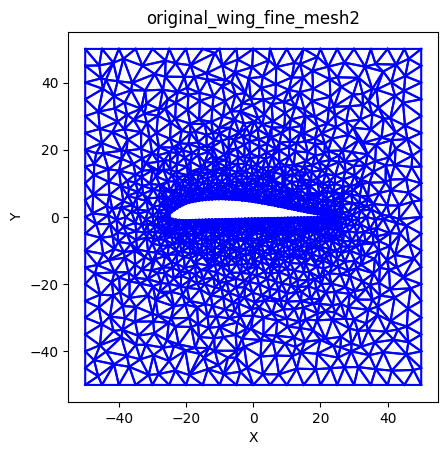

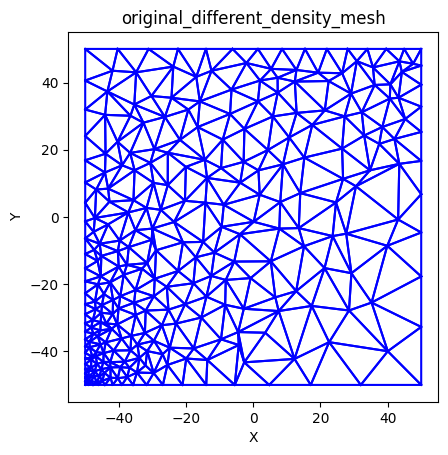

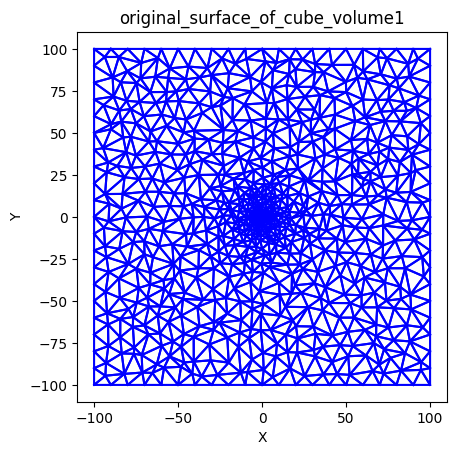

In [25]:
for i in range(num_train_mesh):
    plot_mesh(train_mesh_data_list[i], f"original_{train_vtk_filenames[i]}")

# 最終的な最適化したメッシュを生成してvtkファイルで出力する

In [26]:
# TensorBoard用のログディレクトリを指定
writer = SummaryWriter(log_dir="/mnt/log/test" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "train")

  0%|          | 0/40 [00:44<?, ?it/s]


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

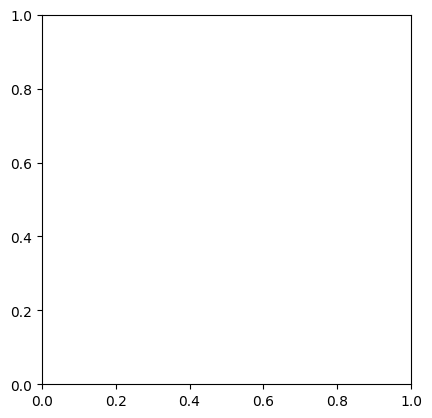

In [26]:
epoch = 0
import torch
torch.autograd.set_detect_anomaly(True)

for j in range(num_train_mesh):                 # 元のメッシュを保存する
        save_mesh(train_mesh_data_list[j], f"trained_{train_vtk_filenames[j]}_{epoch}")
# torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)            
for epoch in tqdm(range(num_train_epoch)):
    #print("epoch:", epoch)
    train(device)
    # print(epoch)

    # for i in range(num_train_mesh):
    #     plot_mesh(train_mesh_data_list[i], f"{i}")
    for j in range(num_train_mesh):             # 最適化したメッシュを保存する
        save_mesh(train_mesh_data_list[j], f"trained_{train_vtk_filenames[j]}_{epoch+1}")


In [28]:
for i in range(num_train_mesh):
    vtk_output(train_mesh_data_list[i], f"trained_{train_vtk_filenames[j]}")

In [29]:

writer.close()


In [30]:
print(model)

GMSNet(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (gcn): GCNConv(64, 64)
  (graph_norm): GraphNorm(64)
  (instance_norm): InstanceNorm1d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)


メモリの開放をする

In [31]:
torch.save(model.state_dict(), 'model_featured_weights.pth')

gc.collect()

if torch.cuda.is_available():
    torch.cuda.empty_cache()